# Multi Scenario MORDM
## Goal of the notebook 


Goal of this notebook is to find robust policies that are fitting to the goals of the Delta Commission.
The search is started by using the worst case scenario from the open exploration phase. This search will yield policy candidates. These policies will then be assessed on the number of deaths they produce under the worst case scenario and the best policies will be evaluated using Multi Scenario MORDM. These final candidates will then be investigated, filtered and tested for robustness using signal-to-noise and regret. From this a single policy will be advised to the Delta Commission.

## Importing libraries

In [163]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import pickle
import plotly.express as px
from IPython.display import display


#importing Exploratory Modelling and Analysis Workbench
from ema_workbench import (Model, MultiprocessingEvaluator, ema_logging, Policy, Scenario, ScalarOutcome)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.analysis import prim, pairs_plotting, parcoords
from ema_workbench.util.utilities import load_results

from problem_formulation import get_model_for_problem_formulation

#turn on logging for errors
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [168]:
#Model setup with problem formulation 2
dike_model, planning_steps = get_model_for_problem_formulation(2)

#Copy XLR instances for easier access
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)
outcomes = copy.deepcopy(dike_model.outcomes)

## The worst case scenario
The worst case scenario was found by analysis of the open exploration notebook. Details on the selection can be found in said notebook.


In [169]:
#import worst case scenario from OpenExploration notebook from results
worst_case_experiment, worst_case_result = load_results('./results/worstcase_scenario_pf1_30000_scenario.tar.gz')

[MainProcess/INFO] results loaded successfully from C:\Users\folke\OneDrive\Desktop\EPA\EPA1361 Model-based Decision-making\epa1361_open-master\epa1361_open-master\final assignment\results\worstcase_scenario_pf1_30000_scenario.tar.gz


In [170]:
#Select only uncertainties
worst_case_scenario = worst_case_experiment.iloc[0, 0:19]

In [171]:
#Create scenario instance from uncertainties
scenarios = []

scen = dict()
for uncertainty in uncertainties:

    scen[str(uncertainty)] = worst_case_scenario[str(uncertainty)]

scenario = Scenario('0', **scen)
scenarios.append(scenario)

# Search for policy candidates
The search for policy candidates starts by optimizing policies to an approximate pareto optimum solution set for worst case scenario using an Multi Objective Evolutionary Algorithm (MOEA). This method is shown effective by (SOURCE). The NFE is picked at 100.000 evaluations with an epsilon of 0.1. This yielded over 2000 solutions under the worst case scenario

In [ ]:

#Search for policies with worst case scenario as reference scenario

ema_logging.log_to_stderr(ema_logging.INFO)

convergence_metrics = [EpsilonProgress()]

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_100kNFE = evaluator.optimize(nfe=100000, epsilons=[.1,]*len(dike_model.outcomes),
                                             reference = scenarios[0], convergence= convergence_metrics, searchover="levers")


In [151]:
results_copy = results_100kNFE

NameError: name 'results_100kNFE' is not defined

In [172]:
#Storing results to results folder using pickle
filename = './results/pickleMORDM_100kNFE_pf2'
outfile = open(filename, 'wb')
pickle.dump(results_copy, outfile)
outfile.close()

NameError: name 'results_copy' is not defined

In [173]:
#Loading results from earlier run.
filename = './results/pickleMORDMtestRun100000NFE_Epsilon0.1_pf2'
infile = open(filename, 'rb')
results_100kNFE = pickle.load(infile)
infile.close()

In [174]:
results, convergence = results_100kNFE

In [175]:
#check number of policy candidates
len(results_100kNFE[0])

2367

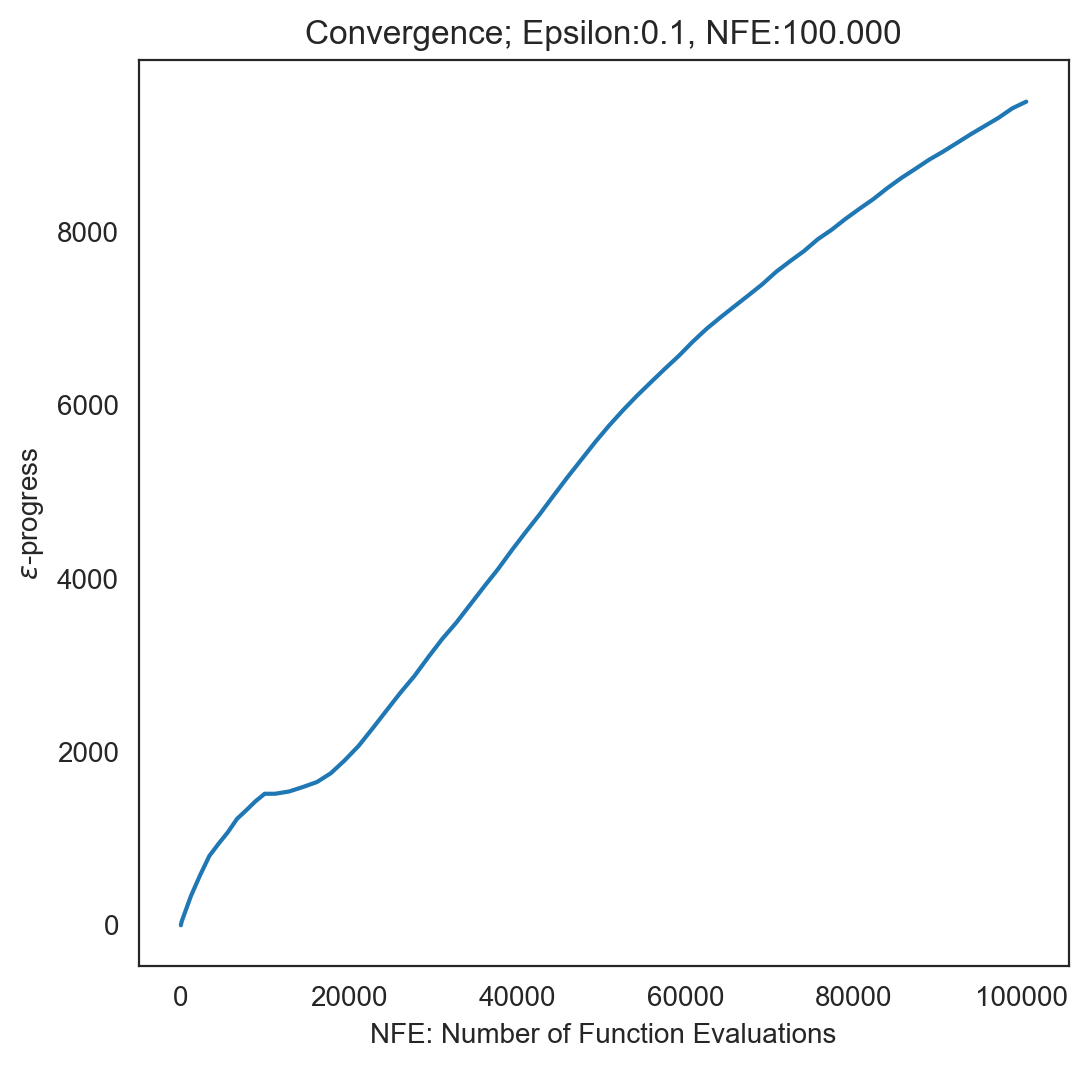

In [286]:
#Plot convergence
plt.figure(figsize=(6, 6), dpi=200)
plt.plot(convergence.nfe,convergence.epsilon_progress)
plt.ylabel('$\epsilon$-progress')
plt.xlabel('NFE: Number of Function Evaluations')
plt.title('Convergence; Epsilon:0.1, NFE:100.000')
plt.savefig('./Figures/Convergenge_PF2_100000NFE_E0_1.png')
plt.show()


### Selecting policy candidates under worst case scenario
In order to ensure appropriate run time a selection has to be made from the over 2000 policies found in the initial MOEA. This selection is done by selecting only the policies that causes fatalities under the worst case scenario to be zero.


In [177]:
#Select a subset with no deaths
results_sub = results[(results["Expected Number of Deaths"] == 0)]

In [178]:
#Check the number of policies left
len(results_sub)

6

In [179]:
#Create list with all policies for robustness analysis
lever_list = []
for lever in levers:
    lever_list.append(str(lever))
policies_list = results_sub[lever_list]
policies_list

worstcase_policies = []

for i, policy in policies_list.iterrows():
    worstcase_policies.append(Policy(str(i), **policy.to_dict()))


## Analysing the robustness of the candidate policies under different scenarios
In order to test the robustness of the policies under different scenarios, the policies have been evaluated against 1000 random scenarios. From these evaluations a pairplot is created that gives the first indication of the effect of these policies on the outcomes under different scenarios.

In [180]:
#Testing robustness under 1000 random scenarios
ema_logging.log_to_stderr(ema_logging.INFO)
n_scenarios = 1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    worst_results = evaluator.perform_experiments(n_scenarios,
                                                  worstcase_policies)
#Save outcome to pickle file
filename = './results/CandidatesRobustnessTest'
outfile = open(filename, 'wb')
pickle.dump(worst_results, outfile)
outfile.close()

KeyboardInterrupt: 

In [216]:
#Load results from earlier run
import pickle
filename = './results/6_worstcase_policies_1000scenarios_each'
infile = open(filename, 'rb')
results_6policies_1000scen = pickle.load(infile)
infile.close()

In [217]:
experiments, outcomes = results_6policies_1000scen

In [219]:
#Assign names of outcomes to list for easier use
outcomes_names = []
for name in outcomes:
    outcomes_names.append(name)

[MainProcess/INFO] no time dimension found in results


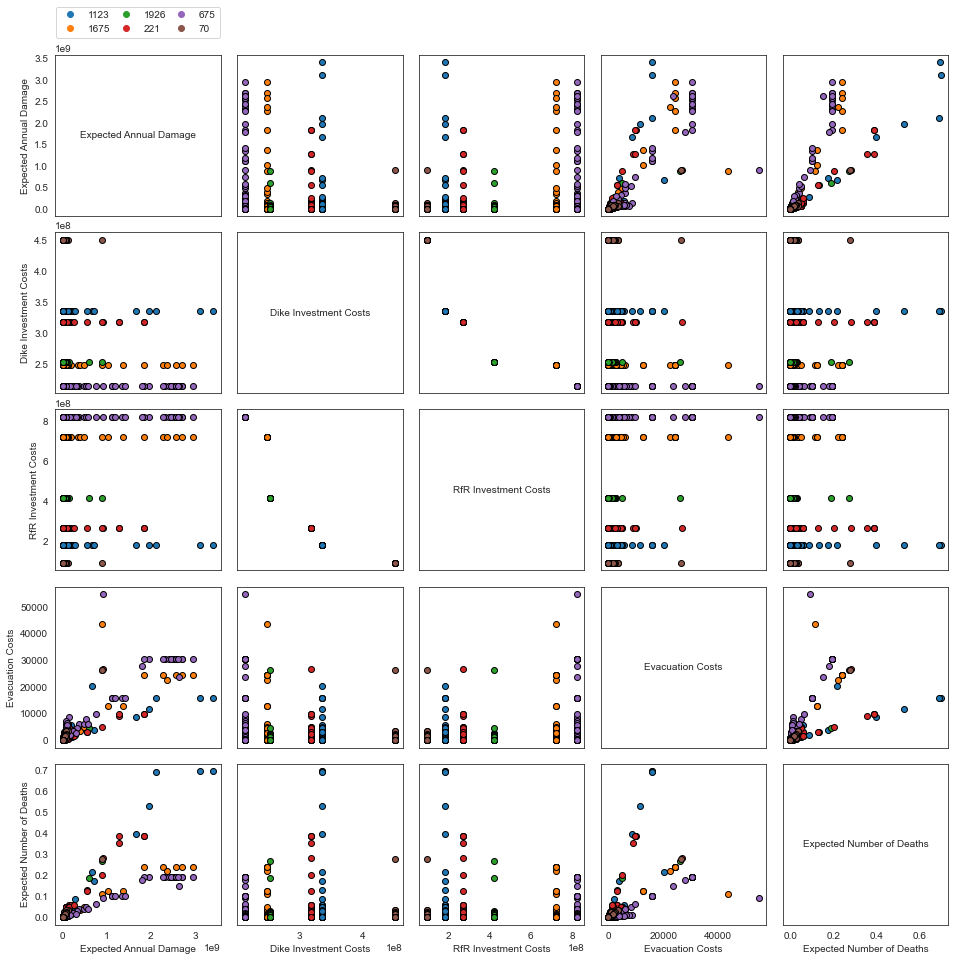

In [267]:
#Create pairplot with the 6 policies and their outcomes
experiments, outcomes = worst_results
fig, axes = pairs_plotting.pairs_scatter(
    experiments, outcomes, group_by="policy", legend=True

)
fig.set_size_inches(16, 16)
plt.savefig('./Figures/6policies_1000scenarios.png')
plt.show()

In [220]:
#Display policies in tabular form
display(results_sub[lever_list].transpose())

,70,221,675,1123,1675,1926
0_RfR 0,0,0,0,0,0,0
0_RfR 1,0,1,0,0,1,1
0_RfR 2,0,0,1,0,1,0
1_RfR 0,0,0,0,0,0,0
1_RfR 1,0,0,1,0,0,0
1_RfR 2,0,0,1,0,1,0
2_RfR 0,1,1,0,0,1,1
2_RfR 1,1,1,1,1,1,1
2_RfR 2,1,0,1,1,1,1
3_RfR 0,0,0,1,1,1,1


In [221]:
#Export policies for analysis and reporting
results_sub[lever_list].transpose().to_excel('./results/candidatesLeversExcel.xlsx')

PermissionError: [Errno 13] Permission denied: './results/candidatesLeversExcel.xlsx'

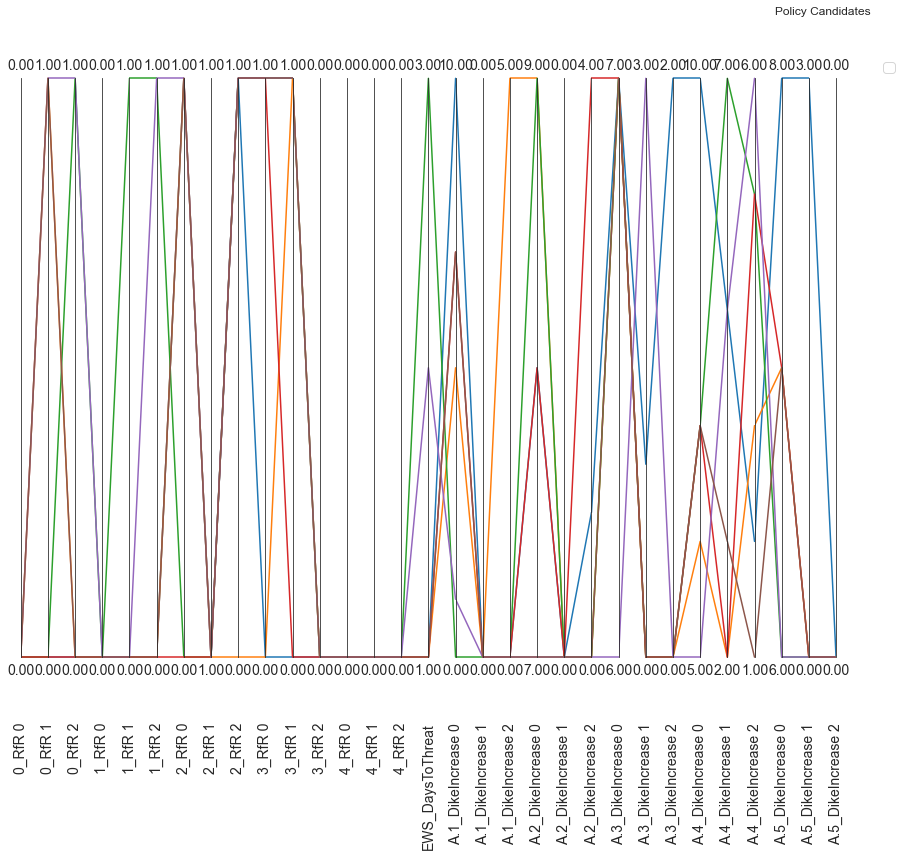

In [231]:
#Plot policies and their lever values against eachother
candidate_levers = results_sub[lever_list]
paraxlimits = parcoords.get_limits(candidate_levers)

paraxes = parcoords.ParallelAxes(paraxlimits)

paraxes.plot(candidate_levers)
plt.title('Policy Candidates')
paraxes.legend()
plt.savefig('./Figures/potentialPolicies.png')
plt.show()



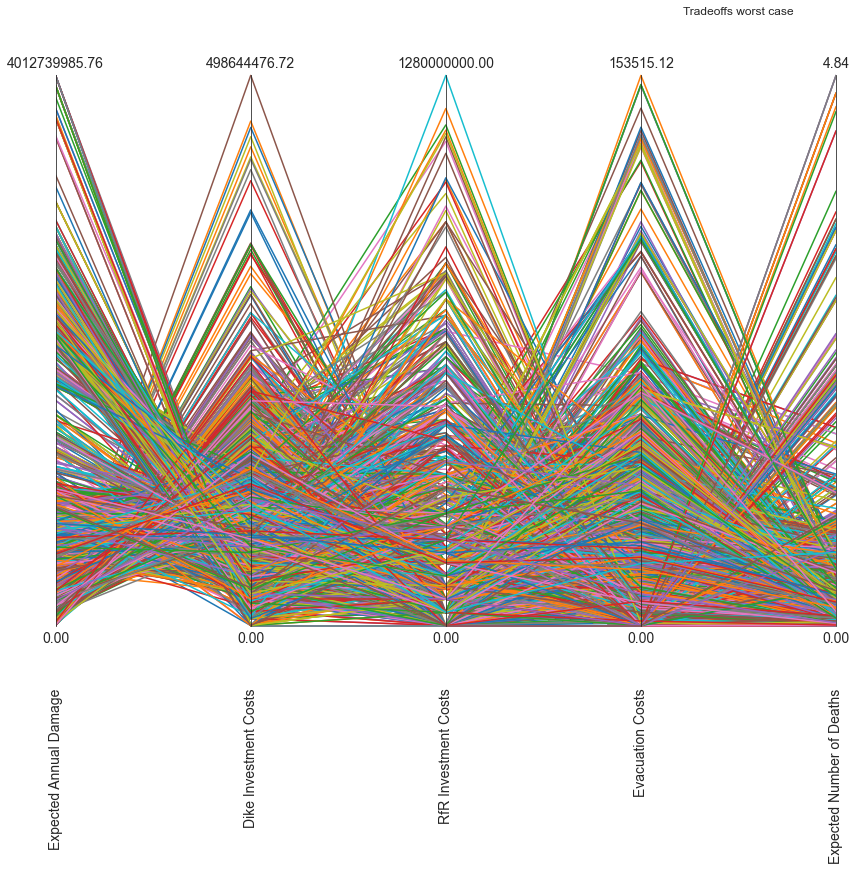

In [268]:
#Plot all evaluations of scenarios and policies in one plot
tradeoffs = results.loc[:, [outcome for outcome in outcomes_names]]
tradeoffs_limits = parcoords.get_limits(tradeoffs)
tradeoffs_limits.loc[0, [outcome for outcome in outcomes_names]]
paraxes = parcoords.ParallelAxes(tradeoffs_limits)

paraxes.plot(tradeoffs)
plt.title('Tradeoffs worst case')
plt.savefig('./Figures/tradeoffworstcase.png')
plt.show()



# Robustness analysis
To check the robustness of the policies their signal to noise and regret scores have been calculated in the following cells.

In [208]:
#Calculate signal to noise for 6 policies and according experiments
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy
    #Calculate Signal to noise for each policy and outcome
    for outcome in outcomes_names:
        value  = outcomes[outcome][logical]
        #As goal is to minimize the outcomes, mean is multiplied with standard deviation
        signal_noise_ratio = np.mean(value)*np.std(value)
        scores[outcome] = signal_noise_ratio
    overall_scores[policy] = scores

signal_noise_ratio_table = pd.DataFrame.from_dict(overall_scores).T
signal_noise_ratio_table

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
1123,3.683961e+15,40.073466,0.0,2.887289e+05,0.000250
1675,4.783776e+15,0.000000,0.0,9.781418e+05,0.000049
1926,1.179910e+14,15.119973,0.0,7.062307e+04,0.000012
221,1.536612e+15,19.004479,0.0,2.359115e+05,0.000110
675,1.771959e+16,0.000000,0.0,3.740849e+06,0.000114
70,8.853271e+13,26.912560,0.0,7.568243e+04,0.000010


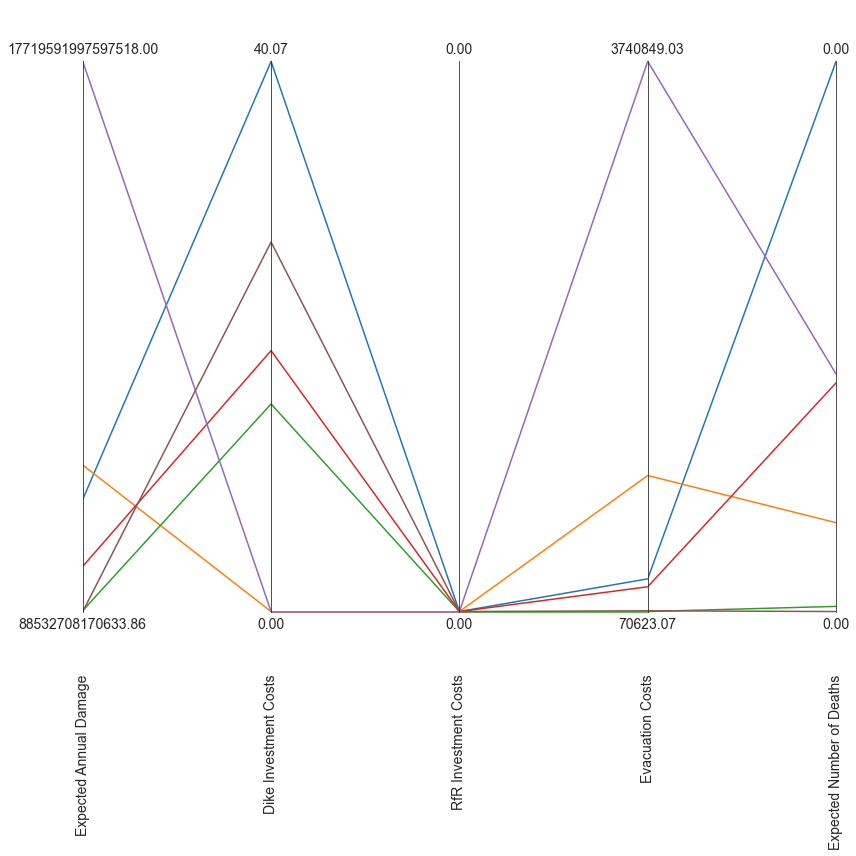

In [280]:
#Plot signal to noise with

s_to_n_data = parcoords.get_limits(signal_noise_ratio_table)
paraxes = parcoords.ParallelAxes(s_to_n_data)

for i, (index, row) in enumerate(signal_noise_ratio_table.iterrows()):
    paraxes.plot(row.to_frame().T, label=index)

plt.savefig('./Figures/parcoordsplotSignalToNoise.png')

plt.show()

## Calculating Regret
Following methods explained in the assignments, regret scores for each policy alternative are calulated and laid out in a heatmap as well as in parallel axis plot

In [256]:
#Calulating regret
overall_scores = {}
regret = []
for scenario in experiments.scenario.unique():
    logical = experiments.scenario==scenario
    temp_results = {k:v[logical] for k,v in outcomes.items()}
    temp_results = pd.DataFrame(temp_results)
    temp_experiments = experiments[experiments.scenario==scenario]

    best = temp_results.max()
    #Regret is calculated as the difference between best and the alternative
    scenario_regret = (temp_results.max(axis=1)[:, np.newaxis] - temp_results).abs()
    scenario_regret['policy'] = temp_experiments.policy.values
    regret.append(scenario_regret)

C:\Users\folke\AppData\Local\Temp/ipykernel_30896/419021873.py:10: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [257]:
#prepare regret data for plotting
regret = pd.concat(regret)
maxregret = regret.groupby('policy').max()

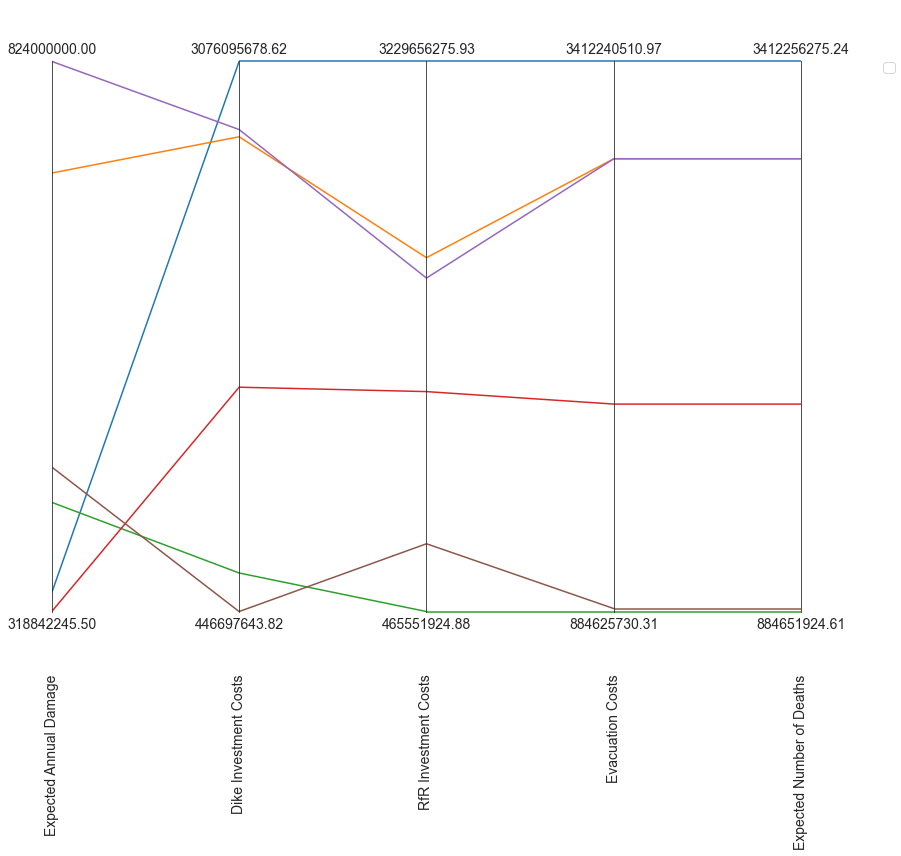

In [281]:
#Plot regret in parallelAxes plot
limits = parcoords.get_limits(maxregret)
paraxes = parcoords.ParallelAxes(maxregret)
paraxes.plot(maxregret)

paraxes.legend()
plt.savefig('./Figures/regretparcoord.png')
plt.show()

## Regret heatmap
Creating a regret heatmap will show the regret of each policy with regards to its alternative.

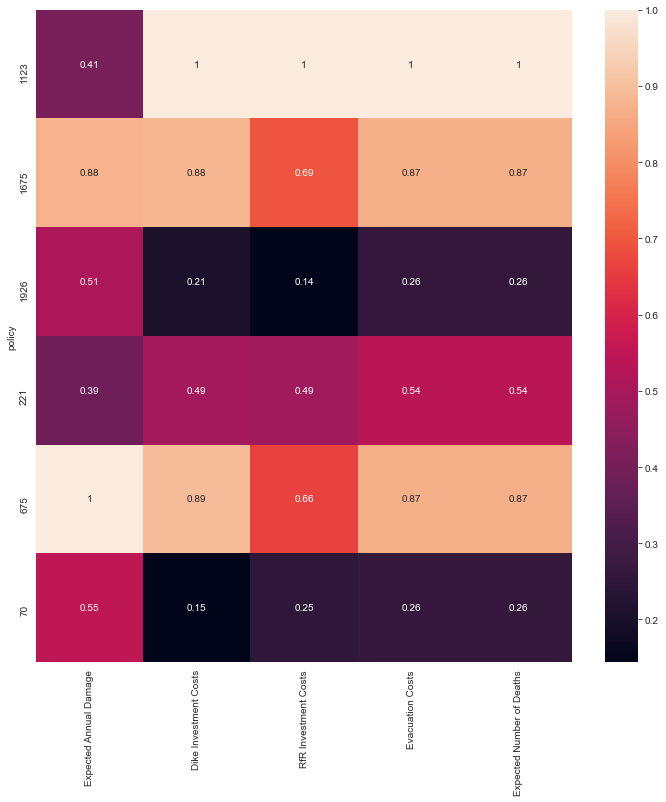

In [279]:
max_regret = pd.DataFrame(maxregret)
plt.figure()
sns.heatmap(max_regret/max_regret.max(), annot=True)

plt.savefig('./Figures/RegretHeatmap.png')
plt.show()